# Debugging bias-variance with learning curves

![Curves](notebooks/bias-variance-learning-curves-files/curves2.jpeg?raw=true "Curves")

In this notebook we build a couple of regression models as an excuse to explore learning and validation curves. These are powerful tools that tell us about the bias and variance in machine learning models.

You can find this code in modules [here](https://github.com/arturomp/coursera-machine-learning-in-python/tree/master/mlclass-ex5-004/mlclass-ex5), along with the files used.

This code was ported from Octave/Matlab to python and was part of the absolutely excellent [Machine Learning course](http://ml-class.org) by Stanford's [Andrew Ng](http://www.andrewng.org) on Coursera.

---

We first import the appropriate libraries:

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## Visualization and data

We can visualize our data points describing water levels in a dam.

Note that we have divided data in training (``X``, ``y``), validation (``Xval``, ``yval``) and testing (``Xtest``, ``ytest``).

If you look at the [full code files](https://github.com/arturomp/coursera-machine-learning-in-python/tree/master/mlclass-ex5-004/mlclass-ex5), you can see more comments on many lines' particular functions, for this or any section going forward.

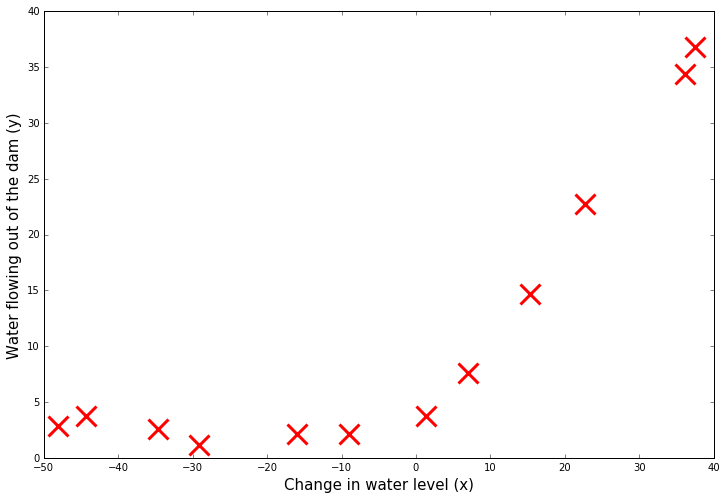

In [35]:
mat = scipy.io.loadmat("notebooks/bias-variance-learning-curves-files/ex5data1.mat")

X = mat["X"]
y = mat["y"]
Xval = mat["Xval"]
yval = mat["yval"]
Xtest = mat["Xtest"]
ytest = mat["ytest"]

m = X.shape[0]

plt.close()
plt.figure(figsize=(12,8))
plt.plot(X, y, 'rx', markersize=20, mew=3)
plt.xlabel('Change in water level (x)', fontsize=15)
plt.ylabel('Water flowing out of the dam (y)', fontsize=15)
plt.show() 

Now we implement linear regression with a regularized cost function and evaluate the cost and gradient values with fixed ``theta`` parameters.

In [36]:
def linearRegCostFunction(X, y, theta, lambda_val):
    """Compute cost and gradient for regularized linear 
    regression with multiple variables
    """
    m = len(y) 
    
    theta = np.reshape(theta, (-1,y.shape[1]))

    J = ( 1./(2*m)) * np.power( (np.dot(X, theta) - y) , 2).sum() + \
                    ( float(lambda_val) / (2*m)) * np.power(theta[1:theta.shape[0]],2).sum()

    grad                   = (1./m) * np.dot( X.T, np.dot(X,theta) - y) + ( float(lambda_val) / m )*theta
    grad_no_regularization = (1./m) * np.dot( X.T, np.dot(X,theta) - y)
    
    grad[0] = grad_no_regularization[0]

    return J, grad.flatten()

The cost should be about 303.993192, and the gradient around (-15.303016, 598.250744).

In [37]:
theta = np.array([[1] , [1]])
X_padded = np.column_stack((np.ones((m,1)), X))
J, grad = linearRegCostFunction(X_padded, y, theta, 1)
print('Cost at theta = [1, 1]: {:f}'.format(J))
print('Gradient at theta = [1, 1]:  [{:f}, {:f}])'.format(grad[0], grad[1]))

Cost at theta = [1, 1]: 303.993192
Gradient at theta = [1, 1]:  [-15.303016, 598.250744])


Remember that regularization with the ``lambda_val`` regularization term helps prevent overfitting by penalizing the cost ``J``. As the parameters in ``theta`` increase, the penalty increases as well. Smaller parameters results in

1. a simpler hypothesis
2. a smoother function

This makes overfitting more difficult! At the same time, note that if ``lambda_val`` is too large, we force our parameters close to 0 and end up with an an oversimplified, model-assumption trusting, data-ignoring, underfit hypothesis.

We now fit a linear regression model with [``trainLinearReg()``](https://github.com/arturomp/coursera-machine-learning-in-python/blob/master/mlclass-ex5-004/mlclass-ex5/trainLinearReg.py):

In [ ]:
def trainLinearReg(X, y, lambda_val):
    """Trains linear regression given a dataset (X, y) and a
    regularization parameter lambda_val"""
    
    initial_theta = np.zeros((X.shape[1], 1))

    # Short hand for cost function to be minimized
    def costFunc(theta):
        return linearRegCostFunction(X, y, theta, lambda_val)

    maxiter = 200
    results = minimize(costFunc, x0=initial_theta, 
                       options={'disp': True, 'maxiter':maxiter}, method="L-BFGS-B", jac=True)

    theta = results["x"]

    return theta

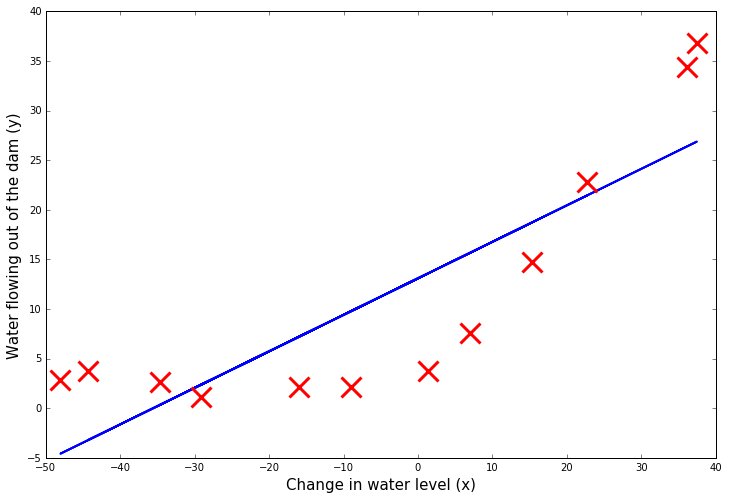

In [21]:
lambda_val = 0
theta = trainLinearReg(X_padded, y, lambda_val)

plt.close()
plt.figure(figsize=(12,8))
plt.plot(X, np.dot(np.column_stack((np.ones((m,1)), X)), theta), '-', linewidth=2)
plt.plot(X, y, 'rx', markersize=20, mew=3)
plt.xlabel('Change in water level (x)', fontsize=15)
plt.ylabel('Water flowing out of the dam (y)', fontsize=15)
plt.show()

It's visually clear that this linear model is a bad fit to the data: the data points don't have a linear pattern. Learning curves will confirm that and make it easy to debug models where the data and fitted models are not as easy to visualize.

## Learning curves as bias-variance diagnostics

Learning curves plot training and validation error as a function of trainng set size. That is, as we get more data, they show how a model trained on that data fares against the same data points it trained on vs. against the validation set. 

Learning curves can be extremely useful in diagnosing machine learning models as they allow us to diagnose bias and variance errors.

Below we graph the learning curves for the linear regression we've worked with so far:

In [ ]:
def learningCurve(X, y, Xval, yval, lambda_val):
    """Generates the train and validation set errors needed 
    to plot a learning curve"""

    m = len(X)

    error_train = np.zeros((m, 1))
    error_val   = np.zeros((m, 1))

    for i in xrange(1,m+1):

        X_train = X[:i]
        y_train = y[:i]

        theta = trainLinearReg(X_train, y_train, lambda_val)

        # note that for error computation, we set lambda_val=0
        error_train[i-1], _ = linearRegCostFunction(X_train, y_train, theta, 0)
        error_val[i-1], _   = linearRegCostFunction(Xval   , yval   , theta, 0)
                
    return error_train, error_val

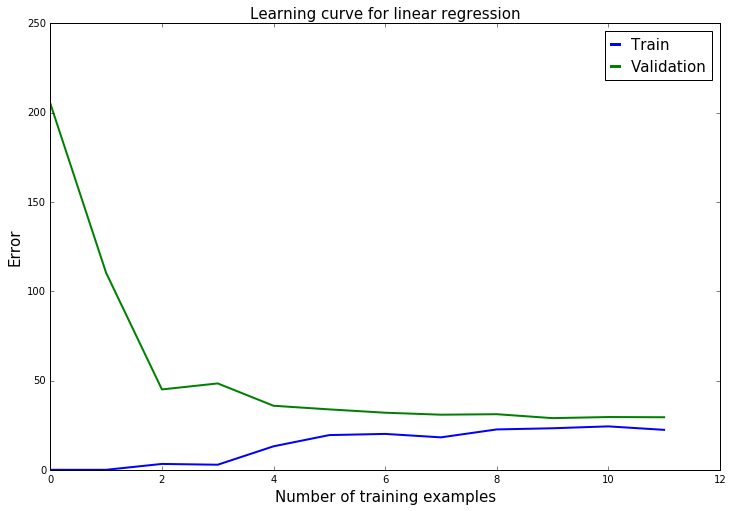

# Training Examples	Train Error	Validation Error

  	1		0.000000	205.121096

  	2		0.000000	110.300366

  	3		3.286595	45.010231

  	4		2.842678	48.368911

  	5		13.154049	35.865165

  	6		19.443963	33.829962

  	7		20.098522	31.970986

  	8		18.172859	30.862446

  	9		22.609405	31.135998

  	10		23.261462	28.936207

  	11		24.317250	29.551432

  	12		22.373906	29.433818



In [22]:
lambda_val = 0
error_train, error_val = learningCurve(np.column_stack((np.ones((m,1)), X)), 
                                       y, 
                                       np.column_stack((np.ones((Xval.shape[0], 1)), Xval)), 
                                       yval, 
                                       lambda_val)

plt.close()
plt.figure(figsize=(12,8))

p1, p2 = plt.plot(range(m), error_train, range(m), error_val, linewidth=2)
plt.title('Learning curve for linear regression', fontsize=15)
legend = plt.legend((p1, p2), ('Train', 'Validation'), numpoints=1, handlelength=0.5, fontsize=15)
for label in legend.get_lines():
    label.set_linewidth(3)
plt.xlabel('Number of training examples', fontsize=15)
plt.ylabel('Error', fontsize=15)
plt.show()
plt.axis([0, 13, 0, 150])

print('# Training Examples\tTrain Error\tValidation Error\n')
for i in xrange(m):
    print('  \t{:d}\t\t{:f}\t{:f}\n'.format(i+1, float(error_train[i]), float(error_val[i])))

The learning curves, which show the error or cost of the model, get close to each other with more training data. At the same time, note that the error is very high for both of them. These two observations indicate that the model has a high bias - its hypothesis is too simple to fit the data properly, and the algorithm weighs its hypothesis more than the data when making predictions.

## More complex regression

We need a model with more features to closer fit our data. 

Polynomial regression allows us to increase the complexity of the model by defining our own features. These new features define a nonlinear relationship between the training data and the output variables - an n-th degree polynomial.

In our case, the new features are powers of the original features. e.g. 

* feature1 = waterLevel
* feature2 = waterLevel$^{2}$
* feature3 = waterLevel$^{3}$
* ...
* featureN = waterLevel$^{N}$

Because we're using powers, it's important to normalize our features so that the numerical optimization works in an efficient manner (or at all).

We obtain polynomial features for the training, test and validation set with the code below.

In [ ]:
def polyFeatures(X, p):
    """Maps X (1D vector) into the p-th power"""

    X_poly = X
    if p >= 2:
        for k in xrange(1,p):
            X_poly = np.column_stack((X_poly, np.power(X,k+1)))
            
    return X_poly

def featureNormalize(X):
    """Normalizes the features in X"""
    
    mu = np.mean(X, axis=0)
    X_norm = X - mu

    sigma = np.std(X_norm, axis=0)
    X_norm = X_norm/sigma

    return X_norm, mu, sigma

In [23]:
p = 8

X_poly = polyFeatures(X, p)
X_poly, mu, sigma = featureNormalize(X_poly)  
X_poly = np.column_stack((np.ones((m,1)), X_poly))

X_poly_test = polyFeatures(Xtest, p)
X_poly_test = (X_poly_test - mu) / sigma
X_poly_test = np.column_stack((np.ones((X_poly_test.shape[0],1)), X_poly_test)) # Add Ones

X_poly_val = polyFeatures(Xval, p)
X_poly_val = (X_poly_val - mu) / sigma
X_poly_val = np.column_stack((np.ones((X_poly_val.shape[0],1)), X_poly_val)) # Add Ones

print('Normalized Training Example 1:')
print('  {:s}  '.format(X_poly[0, :]))

Normalized Training Example 1:
  [ 1.         -0.3782437  -0.78866232  0.19032872 -0.7375913   0.32025197
 -0.6171516   0.35983501 -0.53109126]  


Note that even with polynomial features, we still perform linear regression optimization on them.

## Unregularized polynomial regression

Below, we can see the polynomial fit on the data and its learning curves. We set ``lambda_val=0`` to graph unregularized polynomial regression for now.

Note that the graph below will vary depending on the numerical optimization function you use in ``trainLinearReg()``. Here, we use [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.optimize.minimize.html).

In [ ]:
def plotFit(min_x, max_x, mu, sigma, theta, p, left=15, right=25):
    """Plots a learned polynomial regression fit over an existing figure.
    Also works with linear regression.
    """
    x = np.array(np.arange(min_x - left, max_x + right, 0.05))

    X_poly = polyFeatures(x, p)
    X_poly = (X_poly - mu) / sigma
    X_poly = np.column_stack((np.ones((x.shape[0],1)), X_poly))

    plt.plot(x, np.dot(X_poly, theta), '-', linewidth=2)
    
def plotPolyReg(lambda_val=1):
    theta = trainLinearReg(X_poly, y, lambda_val)

    plt.close()
    plt.figure(figsize=(12,8))

    plt.plot(X, y, 'rx', markersize=10, mew=3)
    plotFit(min(X), max(X), mu, sigma, theta, p, right=15)
    plt.xlabel('Change in water level (x)', fontsize=15) 
    plt.ylabel('Water flowing out of the dam (y)', fontsize=15)
    plt.title ('Polynomial Regression Fit (lambda = {:f})'.format(lambda_val), fontsize=15)
    plt.show()

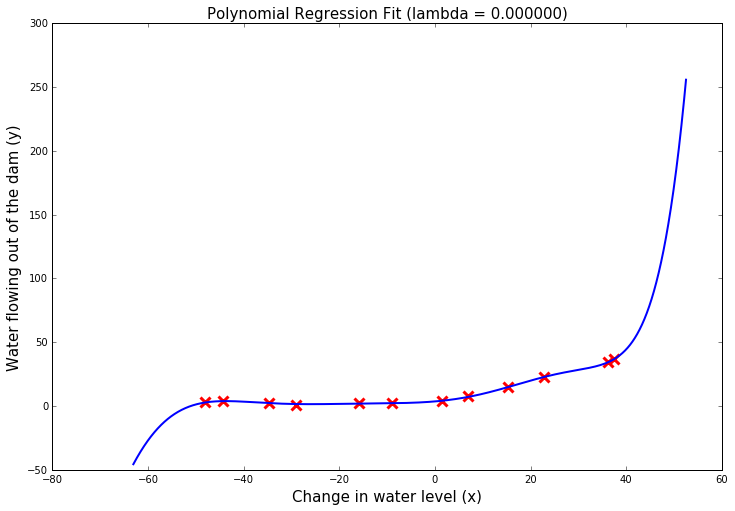

In [24]:
plotPolyReg(lambda_val=0.)

This model fits the data _very_ well. Too well, perhaps. Without regularization, overfitting is somewhat evident in the graph above in how the values dramatically shoot up or down a short distance from the data (notice the scale of the y axis!).

The high variance of the model makes it resemble the data it's trained on too closely, making the model generalize poorly.

We can diagnose high variance with learning curves given that the validation error stays high even as we train with more data. Another indication of high variance in the learning curves is that the training error is at or close to 0  given how tightly overfit the model is.

In [ ]:
def plotPolyLearningCurves(lambda_val=1.):

    plt.close()
    plt.figure(figsize=(12,8))

    error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, lambda_val)
    p1, p2 = plt.plot(range(1,m+1), error_train, range(1,m+1), error_val, linewidth=2)

    plt.axis([0, 13, 0, 100])
    legend = plt.legend((p1, p2), ('Train', 'Validation'), fontsize=15)
    for label in legend.get_lines():
        label.set_linewidth(3)
    plt.title('Polynomial Regression Learning Curve (lambda = {:f})'.format(lambda_val), fontsize=15)
    plt.xlabel('Number of training examples', fontsize=15)
    plt.ylabel('Error', fontsize=15)
    plt.show()

    print('Polynomial Regression (lambda = {:f})\n\n'.format(lambda_val))
    print('# Training Examples\tTrain Error\tValidation Error\n')
    for i in xrange(m):
        print('  \t{:d}\t\t{:f}\t{:f}\n'.format(i+1, float(error_train[i]), float(error_val[i])))

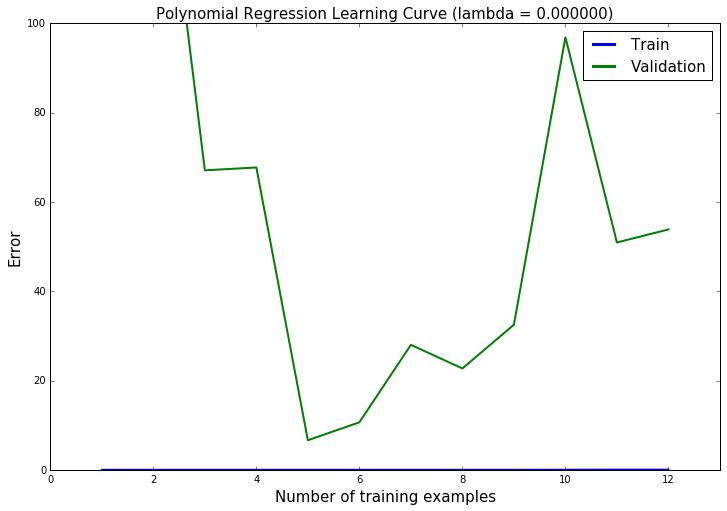

Polynomial Regression (lambda = 0.000000)


# Training Examples	Train Error	Validation Error

  	1		0.000000	161.442168

  	2		0.000000	160.792306

  	3		0.000000	67.085334

  	4		0.000000	67.726856

  	5		0.000000	6.617001

  	6		0.000000	10.641948

  	7		0.000000	27.990140

  	8		0.000000	22.704612

  	9		0.000258	32.498514

  	10		0.010818	96.883940

  	11		0.031219	50.927977

  	12		0.028890	53.837921



In [25]:
plotPolyLearningCurves(lambda_val=0)

## Regularized polynomial regression

We can try different values for ``lambda_val`` and, with the help of learning curves, see the effects of regularization on our model. We start with ``lambda_val=1``:

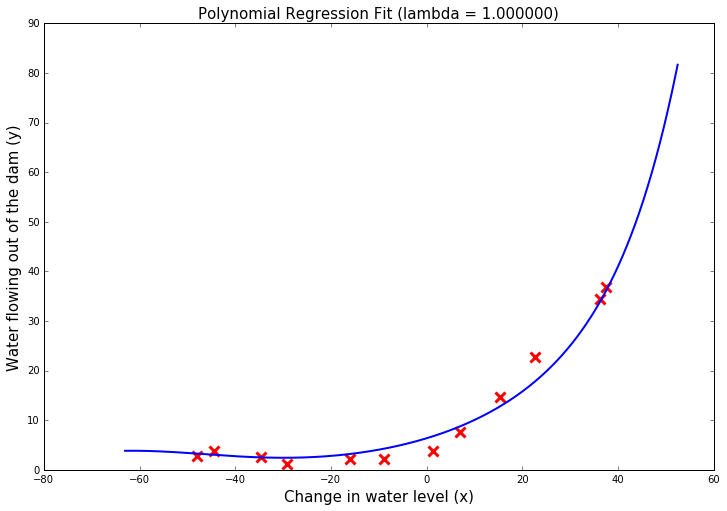

In [26]:
plotPolyReg(lambda_val=1.)

We can see the the model beyond our data doesn't have violent changes up our down. We seem to have balanced variance error - the model is no longer oversensitive to each data point - with the bias error - the model's assumption that the data has a polynomial behaviour is not too far off. 

Learning curves confirm that this regularized model is a decent fit. As we increase the training data size, we see lower error values for both the validation and training data. Both errors are also close to 0 (but not too much).

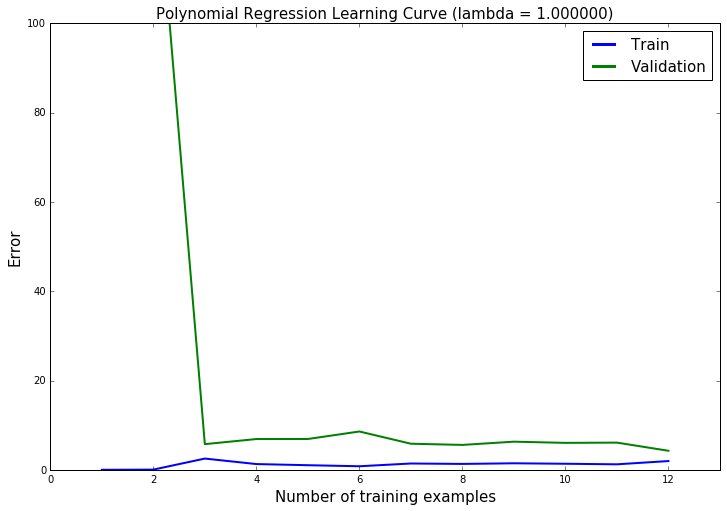

Polynomial Regression (lambda = 1.000000)


# Training Examples	Train Error	Validation Error

  	1		0.000000	138.846731

  	2		0.042839	143.502495

  	3		2.515217	5.749648

  	4		1.285542	6.890110

  	5		1.028307	6.900155

  	6		0.794844	8.581363

  	7		1.409964	5.842339

  	8		1.316231	5.575941

  	9		1.458736	6.300211

  	10		1.353304	6.033562

  	11		1.228546	6.089839

  	12		1.958697	4.263453



In [27]:
plotPolyLearningCurves(lambda_val=1)

We also can go crazy with the regularization and set ``lambda_val=100``:

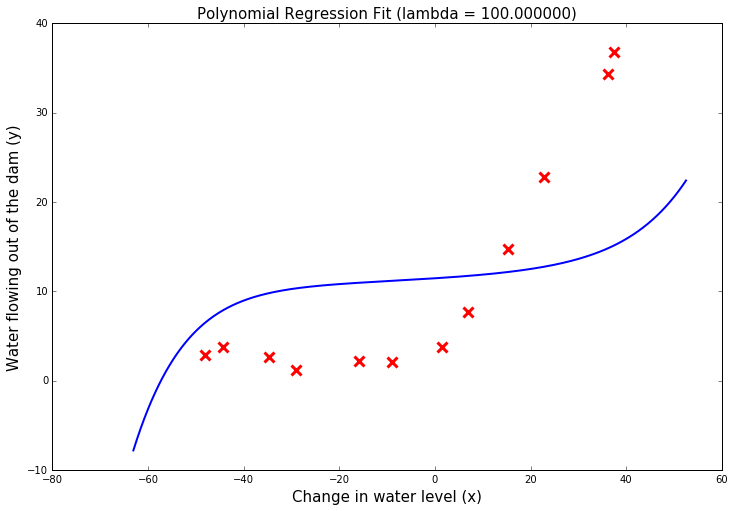

In [28]:
plotPolyReg(lambda_val=100.)

This model, like our initial (nonpolynomial) linear regression, has high bias - it trusts its assumptions too much and doesn't fit the data closely. As before, we see converging train and validation data errors that are both too high.

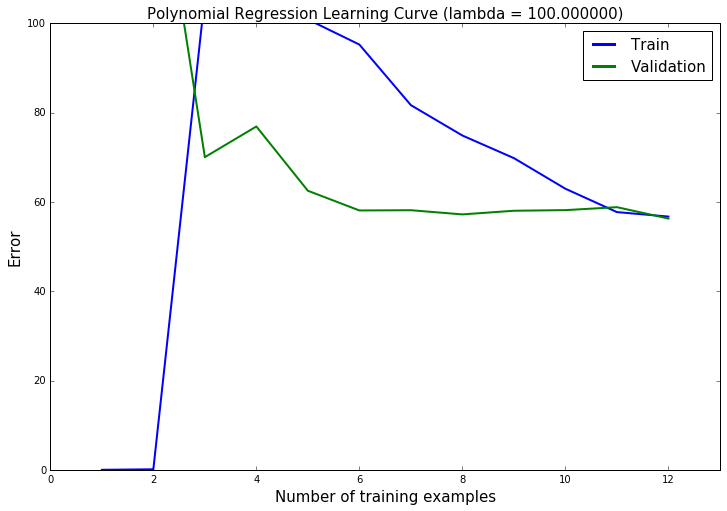

Polynomial Regression (lambda = 100.000000)


# Training Examples	Train Error	Validation Error

  	1		0.000000	138.846777

  	2		0.113986	144.124029

  	3		105.959154	70.036422

  	4		119.945285	76.910566

  	5		100.886412	62.513581

  	6		95.257984	58.095056

  	7		81.687969	58.149081

  	8		74.884577	57.213744

  	9		69.819836	58.029974

  	10		62.963981	58.171676

  	11		57.731688	58.833223

  	12		56.725813	56.287752



In [29]:
plotPolyLearningCurves(lambda_val=100.)

## Picking the regularization term automatically using the validation set

Given how much ``lambda_val`` can change the performance of our model, we want to explore a few possible values for it and pick the best one. Doing this automatically (and visually) is even better.

We explore the following range of values for ``lambda_val`` {0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10} and graph their training and validation errors. We'll then look to see which value of ``lambda_val`` has the lowest error for both trainig and validation data.

In [ ]:
def validationCurve(X, y, Xval, yval):
    """Generate the train and validation errors needed to
    plot a validation curve that we can use to select lambda"""
    lambda_vec = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])

    error_train = np.zeros((len(lambda_vec), 1))
    error_val = np.zeros((len(lambda_vec), 1))

    for i in xrange(len(lambda_vec)):

        lambda_val = lambda_vec[i]

        theta = trainLinearReg(X, y, lambda_val)

        # note that for error computation, we set lambda_val = 0 
        error_train[i], _ = linearRegCostFunction(X,    y,    theta, 0)
        error_val[i], _   = linearRegCostFunction(Xval, yval, theta, 0)
         
    return lambda_vec, error_train, error_val

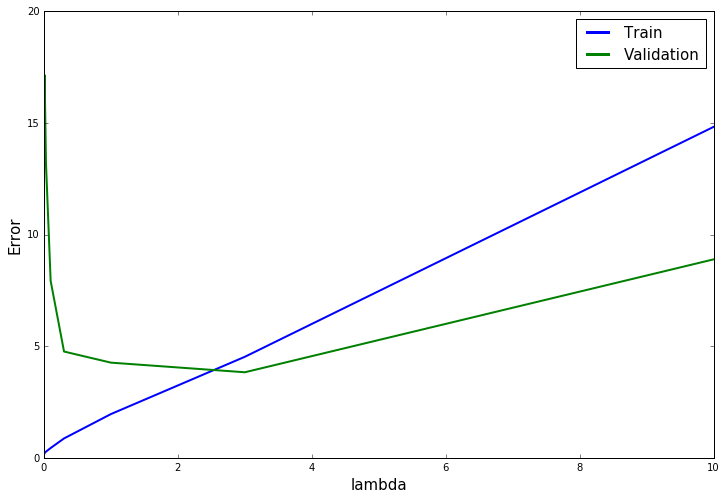

lambda		Train Error	Validation Error

 0.000000	0.028890	53.837921

 0.001000	0.107976	9.350064

 0.003000	0.166720	15.919731

 0.010000	0.217958	17.149315

 0.030000	0.275149	13.216183

 0.100000	0.438656	7.926826

 0.300000	0.868209	4.760732

 1.000000	1.958697	4.263453

 3.000000	4.525101	3.832184

 10.000000	14.825780	8.889697



In [30]:
lambda_vec, error_train, error_val = validationCurve(X_poly, y, X_poly_val, yval)

plt.close()
plt.figure(figsize=(12,8))
p1, p2 = plt.plot(lambda_vec, error_train, lambda_vec, error_val, linewidth=2)
legend = plt.legend((p1, p2), ('Train', 'Validation'), fontsize=15)
for label in legend.get_lines():
    label.set_linewidth(3)
plt.xlabel('lambda', fontsize=15)
plt.ylabel('Error', fontsize=15)
plt.axis([0, 10, 0, 20])
plt.show()

print('lambda\t\tTrain Error\tValidation Error\n')
for i in xrange(len(lambda_vec)):
    print(' {:f}\t{:f}\t{:f}\n'.format(lambda_vec[i], error_train[i][0], error_val[i][0]))

The lowest validation error happens when ``lambda_val=3``, which is the optimal choice from the range explored.

## Evaluating tuned model on test set

Now that we have tuned the ``lambda_val`` value with the validation set, we can finally use it to compute the error on the test set. It should be around 3.8599.

In [31]:
lambda_val = 3
theta = trainLinearReg(X_poly, y, lambda_val)

error_test = linearRegCostFunction(X_poly_test, ytest, theta, 0)
print('Test set error: {:f}\n'.format(error_test[0]))

Test set error: 3.572020



Even better! 

## Learning curves with randomly selected examples

With such a small learning set, it often helps to plot learning curves with the average of different randomly selected data from your training and validation set.

For $i$ examples, we randomply pick $i$ data points from the training set and $i$ data points from the validation set. We learn the regression parameters using the chosen training set, and then evaluate the error of those parameters with the same training set and with the chosen validation set. We repeat this many times (50 in our case) and use the averaged error as the training and validation error for $i$ examples.

The graphs below show averaged learning curves with randomly picked examples for ``lambda_val=0.01`` and the previously chosen ``lambda_val=3``.

In [32]:
def plotLearningCurvesRandomEx(lambda_val=1., times=50):

    error_train_rand = np.zeros((m, times))
    error_val_rand   = np.zeros((m, times))

    for i in xrange(1,m+1):

        for k in xrange(times):

            # choose i random training examples
            rand_sample_train = np.random.permutation(X_poly.shape[0])
            rand_sample_train = rand_sample_train[:i]

            # choose i random validation examples
            rand_sample_val   = np.random.permutation(X_poly_val.shape[0])
            rand_sample_val   = rand_sample_val[:i]

            # define training and validation sets for this loop
            X_poly_train_rand = X_poly[rand_sample_train,:]
            y_train_rand      = y[rand_sample_train]
            X_poly_val_rand   = X_poly_val[rand_sample_val,:]
            yval_rand         = yval[rand_sample_val]           

            theta = trainLinearReg(X_poly_train_rand, y_train_rand, lambda_val)

            error_train_rand[i-1,k], _ = linearRegCostFunction(X_poly_train_rand, y_train_rand, theta, 0)
            error_val_rand[i-1,k], _   = linearRegCostFunction(X_poly_val_rand,   yval_rand,    theta, 0)


    error_train = np.mean(error_train_rand, axis=1)
    error_val   = np.mean(error_val_rand, axis=1)


    plt.close()
    plt.figure(figsize=(12,8))
    p1, p2 = plt.plot(range(m), error_train, range(m), error_val)
    plt.title('Polynomial Regression Learning Curve (lambda = {:f})'.format(lambda_val), fontsize=15)
    plt.legend((p1, p2), ('Train', 'Validation'), fontsize=15)
    for label in legend.get_lines():
        label.set_linewidth(3)
    plt.xlabel('Number of training examples', fontsize=15)
    plt.ylabel('Error', fontsize=15)
    plt.axis([0, 13, 0, 150])
    plt.show(block=False)


    print('# Training Examples\tTrain Error\tValidation Error\n')
    for i in xrange(m):
        print('  \t{:d}\t\t{:f}\t{:f}\n'.format(i+1, error_train[i], error_val[i]))

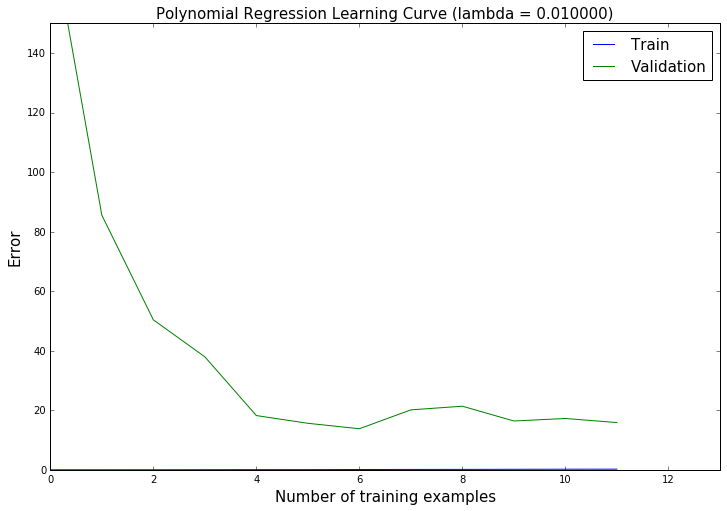

# Training Examples	Train Error	Validation Error

  	1		0.000000	182.877750

  	2		0.003656	85.562485

  	3		0.011556	50.394730

  	4		0.033551	37.958793

  	5		0.051329	18.224140

  	6		0.057915	15.628155

  	7		0.094242	13.797389

  	8		0.122968	20.143734

  	9		0.136763	21.369283

  	10		0.171900	16.398111

  	11		0.199906	17.246456

  	12		0.217958	15.875173



In [33]:
plotLearningCurvesRandomEx(0.01)

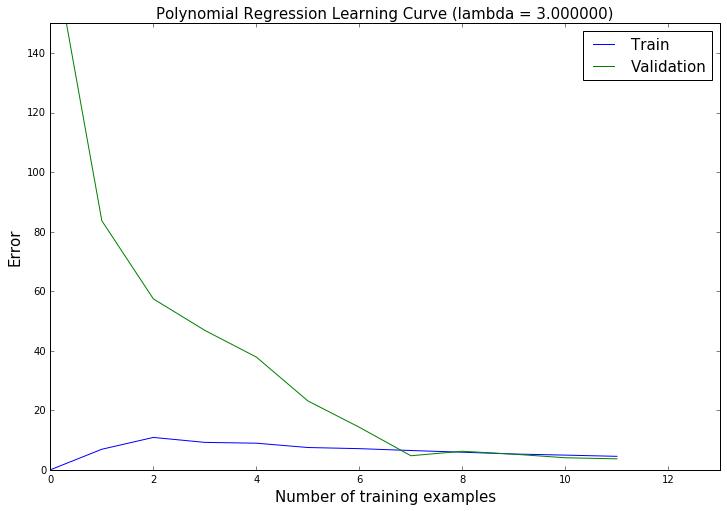

# Training Examples	Train Error	Validation Error

  	1		0.000000	180.185330

  	2		6.905803	83.683827

  	3		10.878026	57.439726

  	4		9.213417	46.845166

  	5		8.941584	37.880179

  	6		7.488739	23.144008

  	7		7.105995	14.287260

  	8		6.479766	4.724394

  	9		5.914499	6.231427

  	10		5.302415	5.247132

  	11		4.933575	4.045779

  	12		4.525101	3.679319



In [34]:
plotLearningCurvesRandomEx(3)